# Example1

**This is adapted from https://github.com/svenreiche/Genesis-1.3-Version4/tree/master/examples/Example1-SteadyState**

Steady-state simulations are the simplest form to run Genesis, where the variation along the electron bunch and radiation field is assumed constant. Field distribution, which slips out of the electron slice is replaced with an identical field, slipping in. Internally, Genesis disables any slippage and it is sufficient to simulate only a single slice with the length of the wavelength of interest. Note this is identical to a single frequency model.

In the following the setup input and lattice file are explained in some detail. Since this is the first example it starts from scratch.

In [15]:
from genesis.version4 import Genesis4

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' # Nicer plots

## The Lattice File
The lattice file contains the physical definition of the undulator beamline, including the types, their position and strengths. The example follows the lattice of the SwissFEL hard X-ray beamline Aramis, which places undulator modules in a FODO lattice.

The first is to define the undulator module, which is used for all instances in the lattice. The given line in the lattice file is shown in the next cell.  Note that we are using the command [grep](https://en.wikipedia.org/wiki/Grep) to search through the lattice file.

In [2]:
!grep "UND:" data/example1-steadystate/Example1.lat

UND: UNDULATOR = { lambdau=0.015000, nwig=266, aw=0.84853, helical= True};


The tag `UND` is a label to used to refer latter in the file to this element. The type is defined by the keyword `UNDULATOR` followed by a list of parameters, placed in a curly bracket. Here the undulator period is 15 mm, the module has 266 undulator periods, and the rms undulator parameter is 0.84853. The undulator has a helical configuration.

Next, two quadrupoles are defined with opposite polarity. A positive value means that the beam is focussed in the x-plane. The field strength are normalized (independent from the explicit electron beam energy) and has the unit of inverse meter squared. An estimate of the focal strength is f = 1/k1*l. With a length of 8 cm it is in this case 6.25 m.

In [3]:
!grep "QUADRUPOLE" data/example1-steadystate/Example1.lat

QF: QUADRUPOLE = { l = 0.080000, k1= 2.000000 };
QD: QUADRUPOLE = { l = 0.080000, k1= -2.000000 };


Two drift lengths of 44 and 24 cm respectively defines the space before and after the quadrupole.

In [4]:
!grep "DRIFT" data/example1-steadystate/Example1.lat

D1: DRIFT = { l = 0.44};
D2: DRIFT = { l = 0.24};


The explicit layout is defined with the `LINE` command: a list of basic elements (e.g. undulator, quadrupoles) or other lines. 

Note that Genesis 1.3 allows only a recursion depth of 10, where a line is placed as an element of an outline. 

The basic arrangement is:
* Undulator Module
* Drift
* Focusing Quadrupole
* Drift
* Undulator Module
* Drift
* Defocusing Quadrupole Drift

In [5]:
!grep "FODO:" data/example1-steadystate/Example1.lat

FODO: LINE={UND,D1,QF,D2,UND,D1,QD,D2};


The label of this subsection of the full beamline is `FODO`. In the full beamline, the `FODO` lattice has 6 periodic cells.

In [6]:
!grep "FEL:" data/example1-steadystate/Example1.lat

FEL: LINE={6*FODO};


Putting it all together, here is our complete lattice input file:

In [7]:
!cat data/example1-steadystate/Example1.lat

D1: DRIFT = { l = 0.44};
D2: DRIFT = { l = 0.24};
QF: QUADRUPOLE = { l = 0.080000, k1= 2.000000 };
QD: QUADRUPOLE = { l = 0.080000, k1= -2.000000 };
UND: UNDULATOR = { lambdau=0.015000, nwig=266, aw=0.84853, helical= True};

FODO: LINE={UND,D1,QF,D2,UND,D1,QD,D2};

FEL: LINE={6*FODO};


## The Main Input File

The main input file is a list of namelists, which are processed in the order they appear in the file. 
It is necessary that the first namelist is &setup, defining some key parameters for the simulation.

In [8]:
!head -n 10 data/example1-steadystate/Example1.in

&setup
rootname=Example1
lattice=Example1.lat
beamline=FEL
lambda0=1e-10
gamma0=11357.82
delz=0.045000
shotnoise=0
nbins = 8
&end


* The `rootname` is used as a prefix when writing any output file.  In this case the main output file would be `Example1.out.h5`.
* The `lattice` parameter specifies the file which describes the beamline elements, as described in the previous section.
* The element `beamline` selects one line in the lattice file to be used for simulation. This allows to have several variants in the lattice file. Setting this to beamline=FODO would actually use only a single FODO cell with two undulator modules instead the 6 cells of the full lattice.
* Two reference values are required, the reference wavelength `lambda0` and reference energy `gamma0`. These do not have necessarily be the FEL wavelength (in SASE simulations) or the electron beam energies, but should not deviate too much for not violating the resonant approximation of the underlying numerical model. 
* `delz` is the preferred integration step size. In our example, there about 3 undulator periods in one step. Genesis will align the step size for each step to resolve each beamline elements correctly.
* Since this is a steady state simulation the impact of the fluctuation in the electron position should be disabled by setting `shotnoise` to `0`. In time-dependent simulation (SASE simulation) this should be set to `1`.
* `nbins` defines the number of particles per beamlet, which is a group of macro particles which share the same coordinate, except for their longitudinal position.

Next, our lattice-related settings in the `lattice` namelist:

```
&lattice
zmatch=9.5
&end
```

For injecting the electron beam into the lattice, the optical function should be defined when initializing the electron beam. Genesis can also calculate the matched solution to the lattice with the lattice namelist.

`zmatch` defines the length over which a periodic solution is assumed. Note that 9.5 is the same value as we calculated for the length of the basic FODO cell in the lattice file.

Next is the definition of the radiation field for the start of the simulation:

```
&field
power=5e3
dgrid=2.000000e-04
ngrid=255
waist_size=30e-6
&end
```

Since this is a steady-state simulation it should have some radiation power.
 
Here the starting power is 5 kW and the field has a size of 30 µm. The physical meaning of `waist_size` is the same as `w0` for a fundamental Gauss mode. With the wavelength (here `lambda0` from the setup namelist) and the waist size the radiation wavefront is well defined.
The wavefront is then placed on a 2D grid with 255 grid points in each direction and an extension between -200 to 200 microns. Note that it is strongly recommended having an odd number of grid points to have the origin of the two grids coincide with the transverse position x=0 and y=0.

The electron beam is then generated with the following namelist:

```
&beam
current=3000
delgam=1.000000
ex=4.000000e-07
ey=4.000000e-07
&end
```

Here the beam has a current of 3 kA, an RMS energy spread of 0.511 MeV (`delgam=1`) and normalized emittances of 400 nm in x and y. Note that the mean beam energy is taken from `setup` and the optical twiss parameters from the matching command in `lattice`. However, one can overwrite the values here if needed.

Up to this point, the input file has the basic setup configuration, matches the lattice and generates one radiation wavefront and one slice of electron distribution. We can then track it:

```
&track
&end
```

In [9]:
G = Genesis4("data/example1-steadystate/Example1.in")

In [10]:
G.verbose = True
output = G.run()

Configured to run in: /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp6s4s0uxt
Running Genesis4 in /var/folders/vy/s8_hc3m10fddm6n_43cf_m8r0000gn/T/tmp6s4s0uxt
/Users/klauer/miniforge3/envs/lume-genesis/bin/genesis4 -l Example1.lat genesis4.in
---------------------------------------------
GENESIS - Version 4.6.6 has started...
Compile info: Compiled by runner at 2024-01-11 18:10:26 [UTC] from Git Commit ID: 
Starting Time: Tue May 21 14:40:15 2024

MPI-Comm Size: 1 node

Opened input file genesis4.in
Parsing lattice file Example1.lat ...
Matching for periodic solution between z = 0 and z = 9.5 :
   betax (m) : 8.53711
   alphax    : -0.703306
   phix (deg): 45.818
   betay (m) : 17.3899
   alphay    : 1.40348
   phiy (deg): 45.818
Generating input radiation field for HARM = 1 ...
Generating input particle distribution...

Running Core Simulation...
Steady-state run
Initial analysis of electron beam and radiation field...
  Calculation: 0% done
  Calculation: 10% done
  Calculation:

<!-- lume-genesis detected Jupyter and will use HTML for rendering. -->

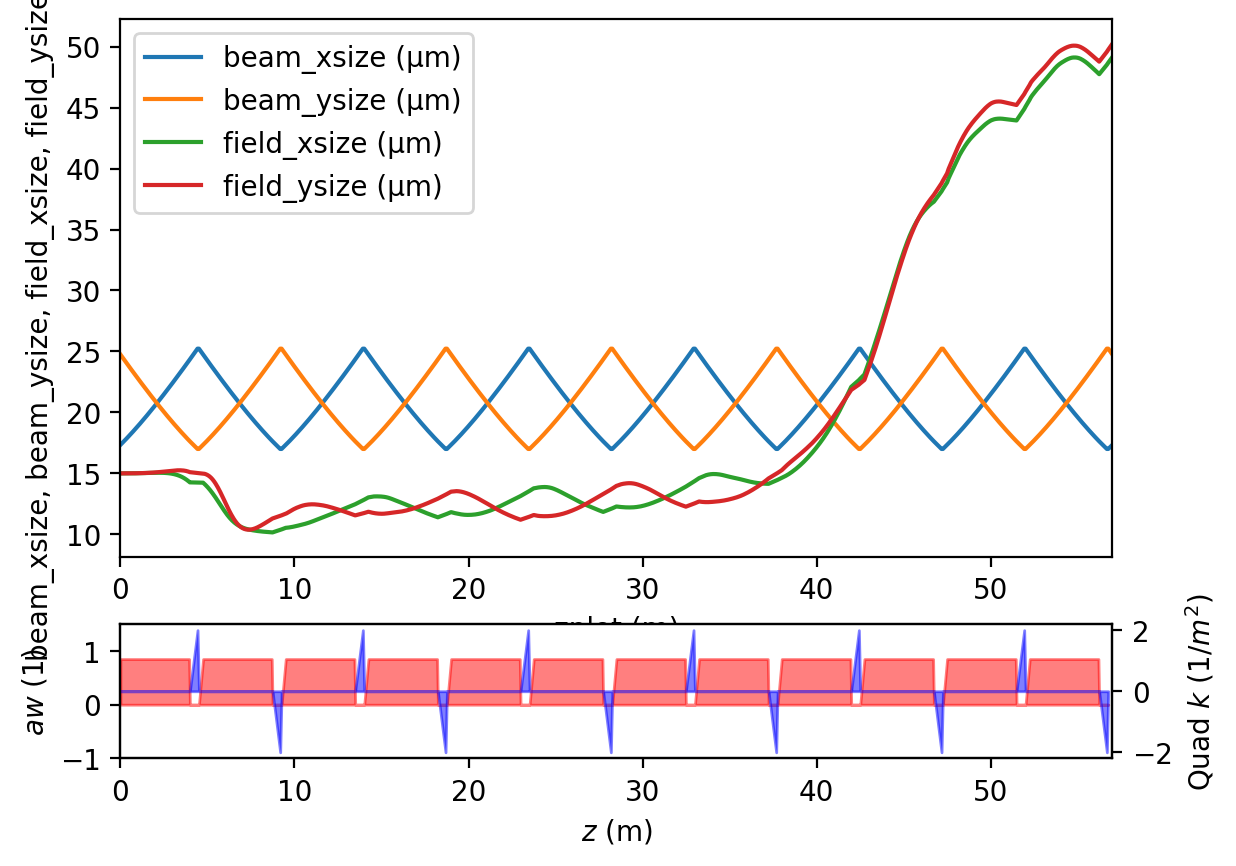

In [11]:
G.plot(["beam_xsize", "beam_ysize", "field_xsize", "field_ysize"])

### Lattice plot

Main undulator field and quadrupole is displayed.

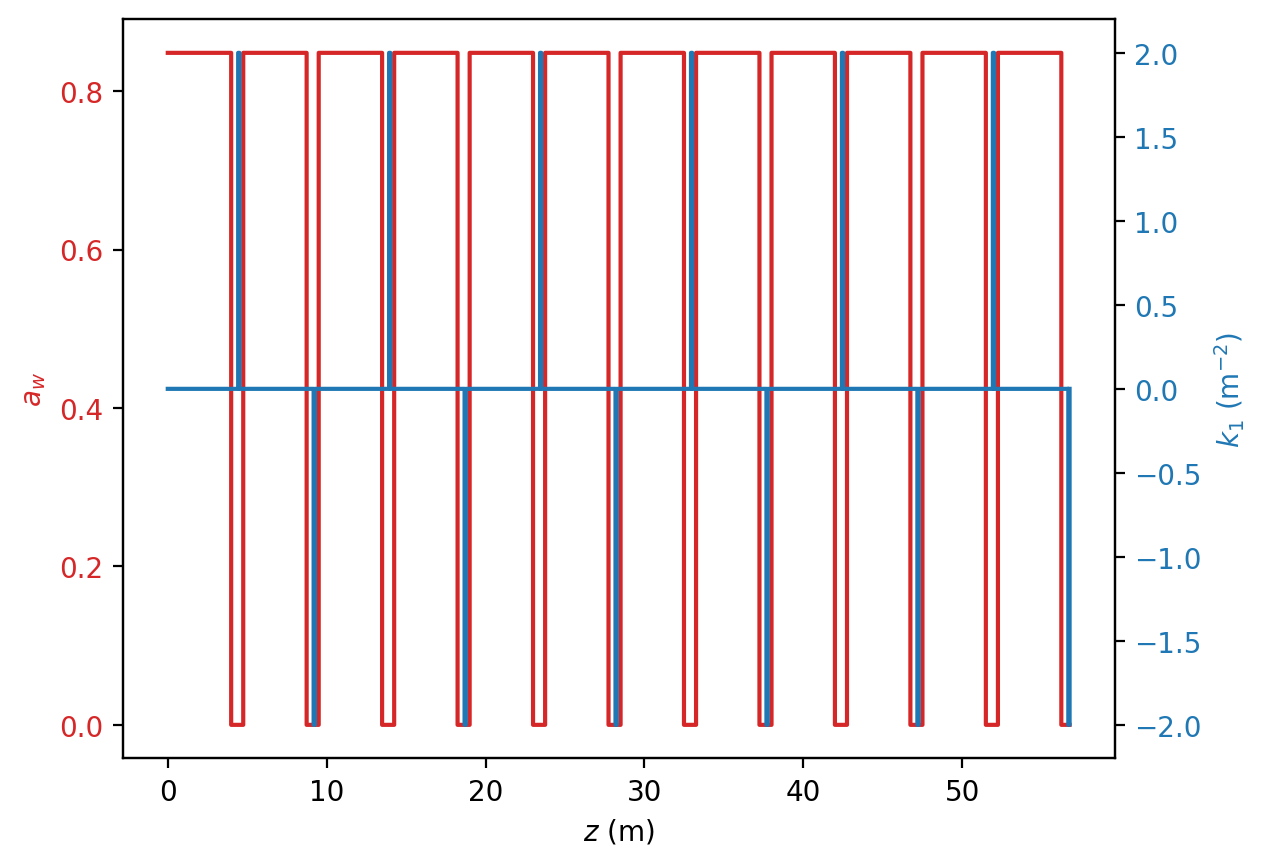

In [12]:
z = output.lattice.z

fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$z$ (m)")
ax1.set_ylabel(r"$a_w$", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.step(z, output.lattice.aw, color=color, where="post")

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$k_1$ (m$^{-2}$)", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.step(z, output.lattice.qf, color=color, where="post")
plt.show()

### Beam and field sizes

While the electron beam has the typical alternating oscillation in its beam size due to the FODO lattice, the radiation field starts with 15 µm (note this should be half of the value `waist_size` in the input deck) but get smaller due to gain guiding. Around 40 m the FEL process reaches saturation and the radiaiton field starts to diverge.

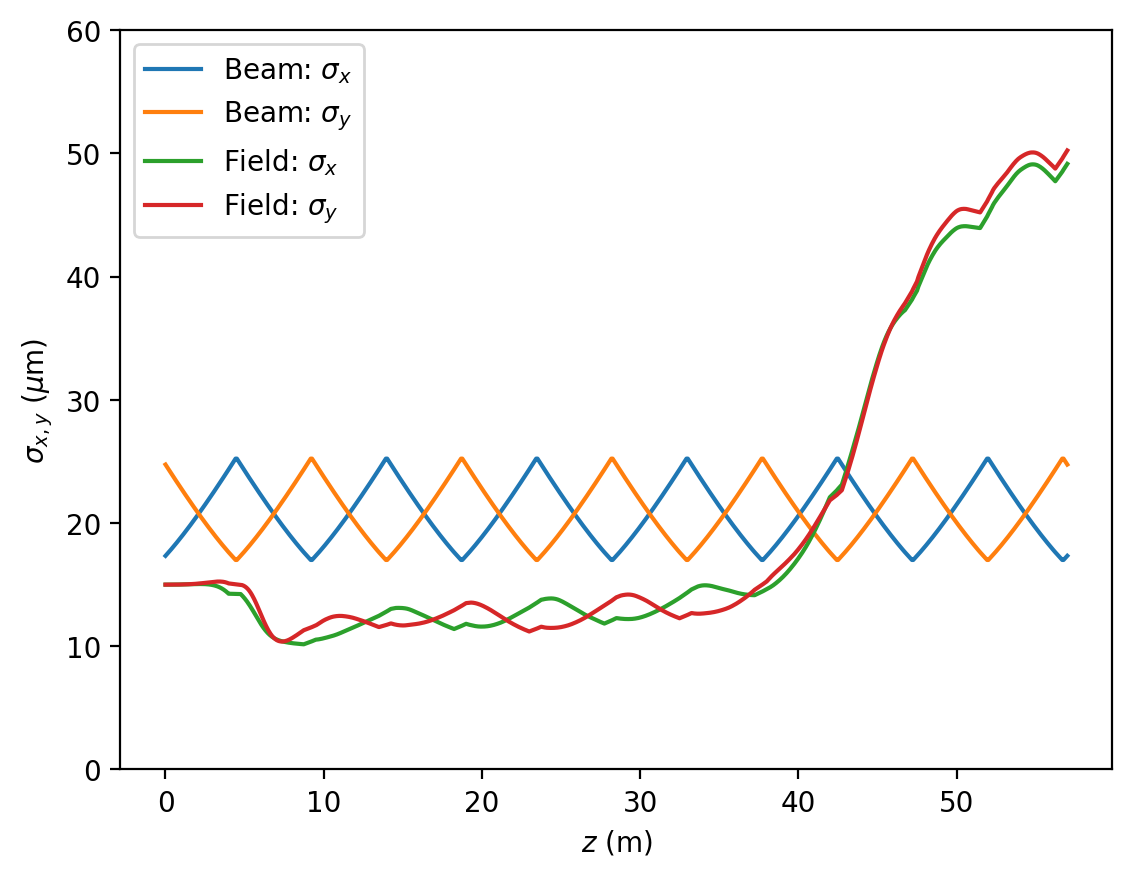

In [13]:
zplot = output.lattice.zplot
field_info = output.field_info
plt.plot(zplot, output.beam.xsize * 1e6, label=r"Beam: $\sigma_x$")
plt.plot(zplot, output.beam.ysize * 1e6, label=r"Beam: $\sigma_y$")
plt.plot(zplot, field_info.xsize * 1e6, label=r"Field: $\sigma_x$")
plt.plot(zplot, field_info.ysize * 1e6, label=r"Field: $\sigma_y$")
plt.legend()
plt.xlabel(r"$z$ (m)")
plt.ylabel(r"$\sigma_{x,y}$ ($\mu$m)")
plt.ylim([0, 60])
plt.show()

### Radiation Power and Bunching

In this log plot one can see the growth of the radiation power and bunching factor till saturation is reached around 40 m. Note that the little dip in power at around 5 m could be optimize by tuning the FEL. This canbe done either by gamma0 in the setup namelist or the value for aw in the lattice file.

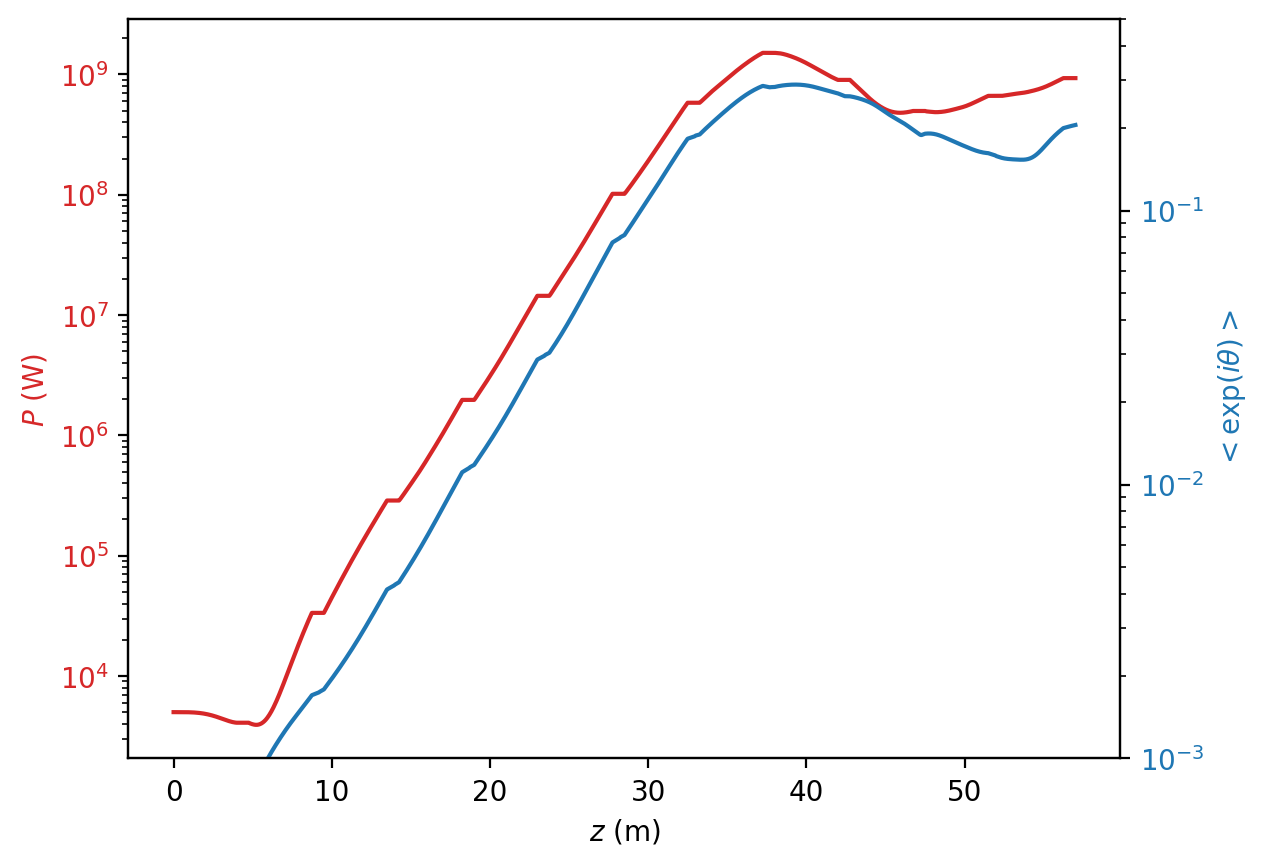

In [14]:
z = output.lattice.zplot
b = output.beam.bunching
p = output.field_info.power

fig, ax1 = plt.subplots()
color = "tab:red"
ax1.set_xlabel(r"$z$ (m)")
ax1.set_ylabel(r"$P$ (W)", color=color)
ax1.tick_params(axis="y", labelcolor=color)
ax1.semilogy(z, p, color=color)

ax2 = ax1.twinx()
color = "tab:blue"
ax2.set_ylabel(r"$<\exp(i\theta)>$", color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.semilogy(z, b, color=color)
ax2.set_ylim([1e-3, 0.5])
plt.show()